In [12]:
import sys

sys.path.append(
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages"
)

import biolib
import gzip
import math
import os
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from io import StringIO
from IPython.display import Image
from matplotlib_venn import venn2
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [13]:
ALL_FASTA_OUTPUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\all_fasta.fasta"
ASSAY_LIST_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\assay-list-olink-explore-3072.xlsx"
)
BRAIN_RNA_SEQ_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\brain_rna_seq.csv"
HGNC_IDS = (
    "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
)
MICROGLIA_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\microglia_fasta.fasta"
)
MATURE_ASTROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\mature_astrocyte_fasta.fasta"
)
OLIGODENDROCYTE_FASTA_OUTPUT_PATH = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\oligodendrocyte_fasta.fasta"
)
PLATE_LAYOUT_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\Plate Layout.xlsx"


RAW_DATA_FILE = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\LCSET_28343_10-4-2023_EXTENDED_NPX_2023-10-20.csv"
UNIPROT_TO_FASTA_PATH = "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\uniprotkb_proteome_UP000005640_2023_11_20.fasta.gz"


PANELS = [
    "Cardiometabolic",
    "Cardiometabolic_II",
    "Inflammation",
    "Inflammation_II",
    "Neurology",
    "Neurology_II",
    "Oncology",
    "Oncology_II",
]


UNIMPORTANT_COLUMNS = [
    "Index",
    "OlinkID",
    "Panel_Lot_Nr",
    "PlateID",
    "WellID",
    "Normalization",
    "Processing_StartDate",
    "Processing_EndDate",
    "AnalyzerID",
    "ExploreVersion",
]


X_AXIS_ORDER = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
    "Plas A Internal EV",
    "Plas B Internal EV",
    "Plas C Internal EV",
    "Plasma D Internal EV",
]

CSF_SAMPLES = [
    "SEC Fract 6 ",
    "SEC Fract 7",
    "SEC Fract 8",
    "SEC Fract 9",
    "SEC Fract 10",
    "SEC Fract 11",
    "SEC Fract 12",
    "SEC Fract 13",
    "SEC Fract 14",
    "SEC Fract 15",
    "CSF A Internal EV",
    "CSF B Internal EV",
    "CSF C Internal EV",
    "CSF D Internal EV",
]

In [14]:
# Clean up the raw OLINK data file and map the sample locations to their barcodes

plate_layout = pd.read_excel(PLATE_LAYOUT_PATH, index_col=0)
raw_data = pd.read_csv(RAW_DATA_FILE, sep=";")
raw_data = raw_data.drop(UNIMPORTANT_COLUMNS, axis=1)

data = pd.merge(raw_data, plate_layout, how="left", on="SampleID")

data["Linear NPX"] = data["NPX"].map(lambda x: 2**x)

In [15]:
vc = data[["SampleID", "Sample_Type", "UniProt"]].value_counts()
vc = vc[vc > 1]
# vc
# # vc.value_counts()
# # vc.index.get_level_values(2).value_counts()
# repeated_markers = vc.index.get_level_values("UniProt").unique()

# markers_in_multiple_panels = data[
#     data["UniProt"].isin(repeated_markers) & (data["Sample_Type"] == "SAMPLE")
# ].pivot(columns=["UniProt", "Panel"], index="SampleID", values="Linear NPX")
# linear_lod = 2 ** (
#     data[
#         data["UniProt"].isin(repeated_markers)
#         & (data["Sample_Type"] == "SAMPLE")
#     ].pivot(columns=["UniProt", "Panel"], index="SampleID", values="LOD")
# )

# markers_in_multiple_panels["P14902"].std(axis=1) / markers_in_multiple_panels[
#     "P14902"
# ].mean(axis=1)

# fig, ax = plt.subplots()
# for marker in repeated_markers:
#     df = markers_in_multiple_panels[
#         markers_in_multiple_panels > linear_lod.fillna(-np.inf)
#     ][marker]
#     x = (df.std(axis=0) / df.mean(axis=0)).median()
#     y = (df.std(axis=1) / df.mean(axis=1)).median()
#     print(marker)
#     print(y)
#     ax.plot([x], [y], "o", alpha=0.25)
#     ax.text(x, y, marker, horizontalalignment="center", verticalalignment="center")
# ax.set(
#     aspect="equal",
#     xlim=(0, 3),
#     ylim=(0, 1),
#     xlabel="Median CV across samples",
#     ylabel="Median CV within sample",
# )

# plt.show()

# markers_in_multiple_panels[markers_in_multiple_panels > linear_lod.fillna(-np.inf)]

In [16]:
# normalize the data according to plate controls

ctrl_dict = {}
for panel in PANELS:
    df = data[(data["Panel"] == panel)]
    plate_ctrl = df[
        (df["Sample_Type"] == "PLATE_CONTROL")
        & (df["Assay"] == "Amplification control 1")
    ]["Linear NPX"].median()
    ctrl_dict[panel] = plate_ctrl

unique_uniprot_values = vc.index.get_level_values("UniProt").unique()
uniprot_list = unique_uniprot_values.tolist()

raw_data_no_reps = data[~data["UniProt"].isin(uniprot_list)].copy()

raw_data_no_reps["Delta"] = raw_data_no_reps.apply(
    lambda row: row["Linear NPX"] - ctrl_dict[row["Panel"]],
    axis=1,
)

# create a tidy dataframe for the delta values
tidy_data = raw_data_no_reps[raw_data_no_reps["Sample_Type"] == "SAMPLE"].pivot(
    columns="UniProt", index=["SampleID", "Health", "Sample"], values="Delta"
)

In [17]:
# Anova test to determine significance of differences between healthy, mild cognitive impairment, and AD samples
assay_list = list(tidy_data.columns)



anova_test = pd.DataFrame(columns=["Assay", "p-value", "Statistic"])

healthy_df = tidy_data[tidy_data.index.get_level_values("Health") == "Healthy"]
mci_df = tidy_data[tidy_data.index.get_level_values("Health") == "MCI"]
ad_df = tidy_data[tidy_data.index.get_level_values("Health") == "AD"]


for assay in assay_list:
    healthy_assays = list(healthy_df[assay])
    mci_assays = list(mci_df[assay])
    ad_assays = list(ad_df[assay])

    statistic, p_value = f_oneway(healthy_assays, mci_assays, ad_assays)
    result_row = pd.DataFrame(
        {"Assay": [assay], "p-value": [p_value], "Statistic": [statistic]}
    )
    anova_test = pd.concat([anova_test, result_row], ignore_index=True)

# print(anova_test["p-value"].mean())
# print(anova_test["p-value"].median())
sig_results = anova_test[anova_test["p-value"] < 0.05]
# sig_results.to_excel("C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\sig_results_anova.xlsx")

# tukey test to correct for differences between these groups
tk_output = pd.DataFrame()

for assay in sig_results["Assay"]:
    healthy_assays = list(healthy_df[assay])
    mci_assays = list(mci_df[assay])
    ad_assays = list(ad_df[assay])
    tk_input = pd.DataFrame(
        {
            "values": healthy_assays + mci_assays + ad_assays,
            "group": ["Healthy Samples"] * len(healthy_assays)
            + ["MCI Samples"] * len(mci_assays)
            + ["AD Samples"] * len(ad_assays),
        }
    )
    tukey_results = pairwise_tukeyhsd(tk_input["values"], tk_input["group"])
    tukey_df = pd.DataFrame(
        tukey_results.summary(), columns=tukey_results.data[0].dtype.names
    )
    tukey_df["Assay"] = assay
    tk_output = pd.concat([tk_output, tukey_df], axis=0)

tk_output = tk_output.rename(
    columns={
        0: "Group 1",
        1: "Group 2",
        2: "Mean Difference",
        3: "Adjusted p-value",
        4: "Lower",
        5: "Upper",
        6: "Reject?",
        "Assay": "Assay",
    }
)
# need to figure out how to drop the rows where "Group 1" is group1, etc.

# man-whitney test
# ks tests between each of the three pairs to see if distribution varies significantly

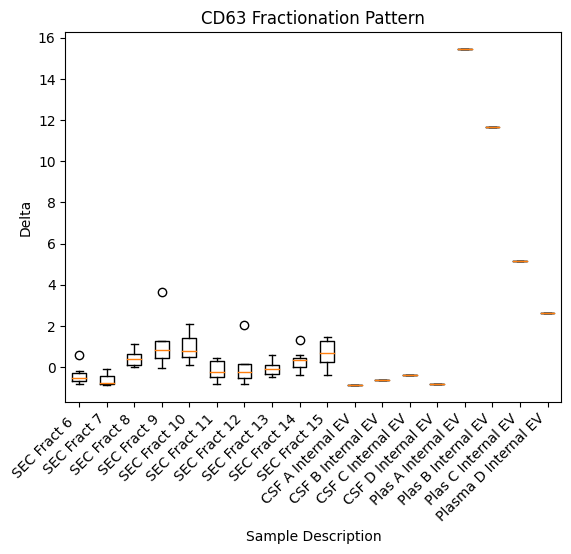

In [19]:
# Graph CD63 medians to confirm correct fractionation pattern
healthy_df = tidy_data[tidy_data.index.get_level_values("Health") == "Healthy"]


cd63 = tidy_data["P08962"]
cd63 = cd63.reset_index(level=["SampleID", "Health", "Sample"])



cd63["Sample"] = pd.Categorical(cd63["Sample"], categories=X_AXIS_ORDER, ordered=True)



cd63_sorted = cd63.sort_values("Sample")



grouped_data = [group["P08962"].values for name, group in cd63_sorted.groupby("Sample")]



plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)



plt.xlabel("Sample Description")



plt.ylabel("Delta")



plt.title("CD63 Fractionation Pattern")



plt.xticks(range(1, len(X_AXIS_ORDER) + 1), X_AXIS_ORDER)



plt.xticks(rotation=45, ha="right")



plt.show()

In [20]:
# Graph some secreted protein medians


def graph_medians(target, uniprot_id):

    df = tidy_data[uniprot_id]
    df = df.reset_index(level=["SampleID", "Health", "Sample"])

    df["Sample"] = pd.Categorical(df["Sample"], categories=CSF_SAMPLES, ordered=True)

    df_sorted = df.sort_values("Sample")

    grouped_data = [
        group[uniprot_id].values for name, group in df_sorted.groupby("Sample")
    ]


    plt.boxplot(grouped_data, notch=None, vert=None, patch_artist=None, widths=None)

    plt.xlabel("Sample Description")

    plt.ylabel("Delta")

    plt.title(f"{target} Fractionation Pattern")

    plt.xticks(range(1, len(CSF_SAMPLES) + 1), CSF_SAMPLES)

    plt.xticks(rotation=45, ha="right")

    plt.show()



# graph_medians("IL1RA", "P18510")



# graph_medians("Apolioprotein E", "P02649")



# graph_medians("Apolioprotein B", "P04114")

In [21]:
# TODO: see how many transmembrane/soluble/cytosolic proteins there are in the dataset and make a pie chart

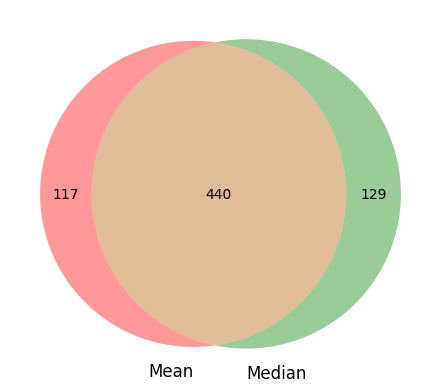

In [53]:
# mean and median fractionation comparison
late_ev_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
]

all_ev_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 7")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 8")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 9")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 10")
]

early_soluble_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 11")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 12")
]

late_soluble_fractions = tidy_data[
    (tidy_data.index.get_level_values("Sample") == "SEC Fract 13")
    | (tidy_data.index.get_level_values("Sample") == "SEC Fract 14")
]

mean_assays = []
median_assays = []

for assay in list(tidy_data.columns):
    late_ev_median = late_ev_fractions[assay].median()
    all_ev_median = all_ev_fractions[assay].median()
    early_soluble_median = early_soluble_fractions[assay].median()
    late_soluble_median = late_soluble_fractions[assay].median()

    late_ev_mean = late_ev_fractions[assay].mean()
    all_ev_mean = all_ev_fractions[assay].mean()
    early_soluble_mean = early_soluble_fractions[assay].mean()
    late_soluble_mean = late_soluble_fractions[assay].mean()

    if ((late_ev_mean > early_soluble_mean) and (all_ev_mean > late_soluble_mean)) or (
        (all_ev_mean > early_soluble_mean) and (late_ev_mean > late_soluble_mean)
    ):
        mean_assays.append(assay)
    if (
        (late_ev_median > early_soluble_median)
        and (all_ev_median > late_soluble_median)
    ) or (
        (all_ev_median > early_soluble_median)
        and (late_ev_median > late_soluble_median)
    ):
        median_assays.append(assay)

venn2(
    [set(mean_assays), set(median_assays)],
    set_labels=("Mean", "Median"),
)

plt.show()

# t-test, mann-whitney U test

In [65]:
# Mann-Whitney U Test

from scipy.stats import mannwhitneyu

late_ev_v_late_soluble = mannwhitneyu(late_ev_fractions, late_soluble_fractions)
late_ev_v_early_soluble = mannwhitneyu(late_ev_fractions, early_soluble_fractions)
all_ev_v_late_soluble = mannwhitneyu(all_ev_fractions, late_soluble_fractions)
all_ev_v_early_soluble = mannwhitneyu(all_ev_fractions, early_soluble_fractions)

In [71]:
# Filter pairs with p-values below 0.05
significant_pairs = []

for result, group1_name, group2_name in [
    (late_ev_v_late_soluble, "Late EV", "Late Soluble"),
    (late_ev_v_early_soluble, "Late EV", "Early Soluble"),
    (all_ev_v_late_soluble, "All EV", "Late Soluble"),
    (all_ev_v_early_soluble, "All EV", "Early Soluble"),
]:
    statistic, p_value = result.statistic, result.pvalue

    if any(p < 0.05 for p in p_value):
        significant_pairs.append((group1_name, group2_name, statistic, p_value))

# Display significant pairs
print("Significant pairs with at least one p-value below 0.05:")
for pair in significant_pairs:
    group1_name, group2_name, statistic, p_value = pair
    print(
        f"{group1_name} vs {group2_name}: U Statistic = {statistic}, P-Value = {p_value}"
    )

Significant pairs with at least one p-value below 0.05:
Late EV vs Late Soluble: U Statistic = [133.  67.  58. ... 184. 120.  60.], P-Value = [0.86532462 0.02259704 0.00880898 ... 0.03646223 0.7774322  0.01095905]
Late EV vs Early Soluble: U Statistic = [149.   88.   98.  ... 166.  152.  147.5], P-Value = [0.43974563 0.13656315 0.26621422 ... 0.15755742 0.37578483 0.4738956 ]
All EV vs Late Soluble: U Statistic = [281.  142.  139.  ... 317.  226.5 130. ], P-Value = [0.59207889 0.0130539  0.01083714 ... 0.18578155 0.5259111  0.00605587]
All EV vs Early Soluble: U Statistic = [307.  187.  231.  ... 280.  294.  302.5], P-Value = [0.26939476 0.13410067 0.59207889 ... 0.60728315 0.41213536 0.31438299]


In [24]:
def calculate_means_and_merge(cell_type_df, not_mean_calc):
    values = cell_type_df.drop(not_mean_calc, axis=1)
    values["Mean"] = values.apply(lambda row: row.mean(), axis=1)
    means = pd.merge(cell_type_df, values["Mean"], left_index=True, right_index=True)
    return means


cell_type_df["Mean"] = cell_type_df.mean(axis=1, numeric_only=True)


def filter_targets(cell_type_means, other_means, threshold):
    return cell_type_means[cell_type_means["Mean"] > (threshold * other_means["Mean"])]


def process_cell_type(brain_rna_seq, cell_type_cols, not_mean_calc, threshold):
    cell_type_df = brain_rna_seq[cell_type_cols]
    cell_type_means = calculate_means_and_merge(cell_type_df, not_mean_calc)

    for other_cell_type_cols in [
        c
        for c in [
            mature_astrocytes_cols,
            microglia_cols,
            oligodendrocyte_cols,
        ]
        if c != cell_type_cols
    ]:
        other_means = calculate_means_and_merge(
            brain_rna_seq[other_cell_type_cols], not_mean_calc
        )
        cell_type_targets = filter_targets(cell_type_means, other_means, threshold)
        cell_type_targets[["Gene", "Species"]] = cell_type_targets["gene_id"].str.split(
            " - ", expand=True
        )
        return cell_type_targets


# Read the brain RNA-seq data
brain_rna_seq = pd.read_csv(BRAIN_RNA_SEQ_PATH)

# Define columns for each cell type
mature_astrocytes_cols = [
    "gene_id",
    "id",
    "astrocytes_mature_1",
    "astrocytes_mature_2",
    "astrocytes_mature_3",
    "astrocytes_mature_4",
    "astrocytes_mature_5",
    "astrocytes_mature_6",
    "astrocytes_mature_7",
    "astrocytes_mature_8",
    "astrocytes_mature_9",
    "astrocytes_mature_10",
    "astrocytes_mature_11",
    "astrocytes_mature_12",
]
microglia_cols = ["gene_id", "id", "microglla_1", "microglla_2", "microglla_3"]
oligodendrocyte_cols = [
    "gene_id",
    "id",
    "oligodendrocytes_1",
    "oligodendrocytes_2",
    "oligodendrocytes_3",
    "oligodendrocytes_4",
    "oligodendrocytes_5",
]
not_mean_calc = ["gene_id", "id"]

# set difference threshold
# Define the threshold for 3x enrichment
cell_type_enrichment_threshold = 3

# Process each cell type
mature_astrocyte_targets = process_cell_type(
    brain_rna_seq, mature_astrocytes_cols, not_mean_calc, cell_type_enrichment_threshold
)
microglia_targets = process_cell_type(
    brain_rna_seq, microglia_cols, not_mean_calc, cell_type_enrichment_threshold
)
oligodendrocyte_targets = process_cell_type(
    brain_rna_seq, oligodendrocyte_cols, not_mean_calc, cell_type_enrichment_threshold
)

# map the hgnc id's to the uniprot id's

response = requests.get(HGNC_IDS)
content = response.text
file_like_object = StringIO(content)
uniprot_ids = pd.read_csv(file_like_object, sep="\t")


def uniprot_and_fractionation(df):
    df = pd.merge(
        df,
        uniprot_ids[["hgnc_id", "uniprot_ids"]],
        left_on="id",
        right_on="hgnc_id",
        how="left",
    )
    return df[df["uniprot_ids"].isin(median_assays)]


mature_astrocyte_targets = uniprot_and_fractionation(mature_astrocyte_targets)
microglia_targets = uniprot_and_fractionation(microglia_targets)
oligodendrocyte_targets = uniprot_and_fractionation(oligodendrocyte_targets)

# microglia_targets = pd.merge(
#     microglia_targets,
#     uniprot_ids[["hgnc_id", "uniprot_ids"]],
#     left_on="id",
#     right_on="hgnc_id",
#     how="left",
# )

# microglia_targets = microglia_targets[
#     microglia_targets["uniprot_ids"].isin(correct_fractionation_median)
# ]

# # Overlay with correct_fractionation_median list
# def find_correct_fractionation(df):
#     return df[df[]]

C:\Users\Wyss User\AppData\Local\Temp\ipykernel_31488\1195275641.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_targets[["Gene", "Species"]] = cell_type_targets["gene_id"].str.split(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_31488\1195275641.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_targets[["Gene", "Species"]] = cell_type_targets["gene_id"].str.split(
C:\Users\Wyss User\AppData\Local\Temp\ipykernel_31488\1195275641.py:29: SettingWithCopyWarning: 
A value is trying

In [26]:
assay_list = pd.read_excel(ASSAY_LIST_PATH)


# map uniprot id's to fasta



def parse_gz_file(file_path):
    protein_dict = {}


    current_uniprot_id = None


    current_sequence = ""


    with gzip.open(file_path, "rt") as f:
        for line in f:
            line = line.strip()


            if line.startswith(">"):
                if current_uniprot_id is not None:
                    protein_dict[current_uniprot_id] = current_sequence


                    current_sequence = ""


                if "|" in line:
                    current_uniprot_id = line.split("|")[1].strip()


                else:
                    print(f"Skipping line without expected format: {line}")


                    current_uniprot_id = None


            else:
                current_sequence += line


        if current_uniprot_id is not None:
            protein_dict[current_uniprot_id] = current_sequence

    return protein_dict



protein_data = parse_gz_file(UNIPROT_TO_FASTA_PATH)



# mature_astrocyte_targets["Sequence"] = assay_list["UniProt ID"].map(


#     lambda x: protein_data.get(x, "N/A")


# )


# microglia_targets["Sequence"] = assay_list["UniProt ID"].map(


#     lambda x: protein_data.get(x, "N/A")


# )


# oligodendrocyte_targets["Sequence"] = assay_list["UniProt ID"].map(


#     lambda x: protein_data.get(x, "N/A")


# )
mature_astrocyte_targets["Sequence"] = mature_astrocyte_targets["uniprot_ids"].map(
    lambda x: protein_data.get(x)
)
microglia_targets["Sequence"] = microglia_targets["uniprot_ids"].map(
    lambda x: protein_data.get(x)
)
oligodendrocyte_targets["Sequence"] = oligodendrocyte_targets["uniprot_ids"].map(
    lambda x: protein_data.get(x)
)



# export the list of proteins in fasta format to be input into the online program


# link to program: https://dtu.biolib.com/DeepTMHMM



def export_fasta(output_path, df):
    with open(output_path, "w") as output_file:
        for index, row in df.iterrows():
            output_file.write(f'>{row["uniprot_ids"]}\n')


            output_file.write(f'{row["Sequence"]}\n')



export_fasta(MATURE_ASTROCYTE_FASTA_OUTPUT_PATH, mature_astrocyte_targets)


export_fasta(MICROGLIA_FASTA_OUTPUT_PATH, microglia_targets)


export_fasta(OLIGODENDROCYTE_FASTA_OUTPUT_PATH, oligodendrocyte_targets)

In [47]:
microglia_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_microglia"
)
oligodendrocyte_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_oligodendrocyte"
)
mature_astrocyte_output_directory = (
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_mature_astrocytes"
)

deeptmhmm = biolib.load("DTU/DeepTMHMM")


def tmhmm_localization(targets, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    os.chdir(output_directory)

    with open("query.fasta", "w") as fasta_file:
        for _, row in targets.iterrows():
            sequence = row["Sequence"]
            uniprot_id = row["uniprot_ids"]
            fasta_line = f">{uniprot_id}\n{sequence}\n"
            print(fasta_line)
            fasta_file.write(fasta_line)
        biolib.utils.STREAM_STDOUT = True  # Stream progress from app in real time
        deeptmhmm_job = deeptmhmm.cli(
            args="--fasta query.fasta", machine="local"
        )  # Blocks until done
        deeptmhmm_job.save_files(output_directory)  # Saves all results to `result` dir


# tmhmm_localization(microglia_targets, microglia_output_directory)
# tmhmm_localization(oligodendrocyte_targets, oligodendrocyte_output_directory)
tmhmm_localization(mature_astrocyte_targets, mature_astrocyte_output_directory)

2023-12-04 19:05:19,932 | INFO : Loaded project DTU/DeepTMHMM:1.0.24
>P08913
MFRQEQPLAEGSFAPMGSLQPDAGNASWNGTEAPGGGARATPYSLQVTLTLVCLAGLLMLLTVFGNVLVIIAVFTSRALKAPQNLFLVSLASADILVATLVIPFSLANEVMGYWYFGKAWCEIYLALDVLFCTSSIVHLCAISLDRYWSITQAIEYNLKRTPRRIKAIIITVWVISAVISFPPLISIEKKGGGGGPQPAEPRCEINDQKWYVISSCIGSFFAPCLIMILVYVRIYQIAKRRTRVPPSRRGPDAVAAPPGGTERRPNGLGPERSAGPGGAEAEPLPTQLNGAPGEPAPAGPRDTDALDLEESSSSDHAERPPGPRRPERGPRGKGKARASQVKPGDSLPRRGPGATGIGTPAAGPGEERVGAAKASRWRGRQNREKRFTFVLAVVIGVFVVCWFPFFFTYTLTAVGCSVPRTLFKFFFWFGYCNSSLNPVIYTIFNHDFRRAFKKILCRGDRKRIV

>P00568
MEEKLKKTKIIFVVGGPGSGKGTQCEKIVQKYGYTHLSTGDLLRSEVSSGSARGKKLSEIMEKGQLVPLETVLDMLRDAMVAKVNTSKGFLIDGYPREVQQGEEFERRIGQPTLLLYVDAGPETMTQRLLKRGETSGRVDDNEETIKKRLETYYKATEPVIAFYEKRGIVRKVNAEGSVDSVFSQVCTHLDALK

>P31751
MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPDQTLPPLNNFSVAECQLMKTERPRPNTFVIRCLQWTTVIERTFHVDSPDEREEWMRAIQMVANSLKQRAPGEDPMDYKCGSPSDSSTTEEMEVAVSKARAKVTMNDFDYLKLLGKGTFGKVILVREKATGRYYAMKILRKEVIIAKDEVAHTVTESRVLQNTRHPFLTALKYAFQTHDRLCFVMEYANGGELFFHLSRE

In [ ]:
# TODO: re-write the program to be run in the opposite order to make sure the output is the same (do transmembrane, then brain rna seq, and then fractionation pattern instead of the other way around)

In [43]:
microglia_internal_results = pd.DataFrame(
    columns=["Length", "Cytosolic Region Start", "Cytosolic Region End"]
)

with open(
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_microglia\\deeptmhmm_results.md",
    "r",
) as microglia_results:
    for line in microglia_results:
        if "Length" in line:
            uniprot_id = line.split()[1]
            length = int(line.split()[-1])
            microglia_internal_results.loc[uniprot_id, "Length"] = length
        elif "	inside" in line:
            uniprot_id = line.split()[0]
            cytosolic_region_start = int(line.split()[-2])
            cytosolic_region_end = int(line.split()[-1])
            microglia_internal_results.loc[
                uniprot_id, "Cytosolic Region Start"
            ] = cytosolic_region_start
            microglia_internal_results.loc[
                uniprot_id, "Cytosolic Region End"
            ] = cytosolic_region_end
microglia_internal_results[
    (microglia_internal_results["Cytosolic Region Start"] == 1)
    & (
        microglia_internal_results["Cytosolic Region End"]
        == microglia_internal_results["Length"]
    )
]

,Length,Cytosolic Region Start,Cytosolic Region End
P07355,339,1,339
P62330,175,1,175
Q7Z6I6,1101,1,1101
P18848,351,1,351
Q9UBW5,565,1,565
Q9NQ88,270,1,270
P49662,377,1,377
Q9Y5K6,639,1,639
P49715,358,1,358
P17676,345,1,345


In [45]:
olig_internal_results = pd.DataFrame(
    columns=["Length", "Cytosolic Region Start", "Cytosolic Region End"]
)

with open(
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_oligodendrocyte\\deeptmhmm_results.md",
    "r",
) as olig_results:
    for line in olig_results:
        if "Length" in line:
            uniprot_id = line.split()[1]
            length = int(line.split()[-1])
            olig_internal_results.loc[uniprot_id, "Length"] = length
        elif "	inside" in line:
            uniprot_id = line.split()[0]
            cytosolic_region_start = int(line.split()[-2])
            cytosolic_region_end = int(line.split()[-1])
            olig_internal_results.loc[
                uniprot_id, "Cytosolic Region Start"
            ] = cytosolic_region_start
            olig_internal_results.loc[
                uniprot_id, "Cytosolic Region End"
            ] = cytosolic_region_end
olig_internal_results[
    (olig_internal_results["Cytosolic Region Start"] == 1)
    & (olig_internal_results["Cytosolic Region End"] == olig_internal_results["Length"])
]

,Length,Cytosolic Region Start,Cytosolic Region End
Q9UBW5,565,1,565
P49662,377,1,377
P09543,421,1,421
P98082,770,1,770
Q9BZ29,2069,1,2069
Q16206,610,1,610
O15083,957,1,957


In [49]:
astrocyte_internal_results = pd.DataFrame(
    columns=["Length", "Cytosolic Region Start", "Cytosolic Region End"]
)

with open(
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\tmhmm_mature_astrocytes\\deeptmhmm_results.md",
    "r",
) as astrocyte_results:
    for line in astrocyte_results:
        if "Length" in line:
            uniprot_id = line.split()[1]
            length = int(line.split()[-1])
            astrocyte_internal_results.loc[uniprot_id, "Length"] = length
        elif "	inside" in line:
            uniprot_id = line.split()[0]
            cytosolic_region_start = int(line.split()[-2])
            cytosolic_region_end = int(line.split()[-1])
            astrocyte_internal_results.loc[
                uniprot_id, "Cytosolic Region Start"
            ] = cytosolic_region_start
            astrocyte_internal_results.loc[
                uniprot_id, "Cytosolic Region End"
            ] = cytosolic_region_end
astrocyte_internal_results[
    (astrocyte_internal_results["Cytosolic Region Start"] == 1)
    & (
        astrocyte_internal_results["Cytosolic Region End"]
        == astrocyte_internal_results["Length"]
    )
]

,Length,Cytosolic Region Start,Cytosolic Region End
